## For possible problems, open an issue, or contact to me  : 
murat dot bronz at gmail dot com

I will try to solve the problem when I have time...

### The best way to use this notebook is to follow the paper on the side

In [3]:
# import all_imports

#!/usr/bin/env python3

from __future__ import print_function, division
import numpy as np
import pandas as pd
from scipy.interpolate import griddata, interp1d

import matplotlib
import matplotlib.pyplot as plt
# %config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.style.use('default')
#plotting lib, but just adding makes the matplotlib plots look better
import seaborn 

import matplotlib as mpl
mpl.style.use('default') #seaborn, default, seaborn-paper

import sklearn
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
# from sklearn import svm
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import sklearn.model_selection as ms

import joblib
from sklearn.metrics import matthews_corrcoef, confusion_matrix, multilabel_confusion_matrix

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
np.set_printoptions(precision=6, suppress=True)


In [2]:
# Try to import PPRZ_DATA (thinking that you have already installed it...)
from pprz_data.pprz_data import DATA

#If that fails : comment the above line and uncomment the below ones to use the cloned git submodule of PPRZ_DATA
# import sys
# sys.path.append("..")         
# from pprz_data.pprz_data import DATA

In [2]:
def add_time_history_1(X,y,n_step=3):
    '''X[0] = Ax0Ay0Az0Gx0Gy0Gz0Ax1Ay1Az1Gx1Gy1Gz1...'''
    time_len= X.shape[0] #-n_step
    column_len = X.shape[1]

    xx=np.zeros((time_len,column_len*n_step))

    for i in range(n_step, time_len):
        for j in range(n_step):
            xx[i,j*column_len:(j+1)*column_len] = X[i-n_step+j]
            
    xx = xx[n_step:X.shape[0],:]
    yy = y[n_step:]
    
    return xx,yy

def add_time_history_2(X,y,n_step=3):
    '''X[0] = Ax0Ax1Ay0Ay1Az0Az1Gx0Gx1Gy0Gy1Gz0Gz1....'''
    time_len = X.shape[0]
    column_len = X.shape[1]

    xx = np.zeros((time_len,column_len * n_step))

    for i in range(n_step,time_len):
        for j in range(column_len):
            xx[i,j*n_step:(j+1)*n_step] = X[(i+0-n_step):(i+0),j]

    xx = xx[n_step:X.shape[0],:]
    yy = y[n_step:]

    return xx,yy

def assign_fault(df):
    df = df.assign(fault=0)
    cond1 = (df['add1'] > 0.005) | (df['add1'] < -0.005)
    cond2 = (df['add2'] > 0.005) | (df['add2'] < -0.005)
    cond3 = (df['m1'] < 1.0) | (df['m2'] < 1.0)
    cond = cond1 | cond2 | cond3
    df.loc[cond,'fault'] = 1
#     cond4 = (df['mode'] == 2.0)
#     df = df[cond4]
    return df

## Load all of the flights from \Data Directory

In [3]:
ac_id = '20'

#########################
filename = '../data/03_07_2020_Faulty_Daredevil/20_07_03__11_13_15_SD.data'
sd03_1 = DATA(filename, ac_id, data_type='flight', sample_period=0.1)
filename = '../data/03_07_2020_Faulty_Daredevil/20_07_03__11_13_58.data'
gcs03_1 = DATA(filename, ac_id, data_type='flight', sample_period=0.1)
df_03_1 = sd03_1.get_labelled_data()

filename = '../data/03_07_2020_Faulty_Daredevil/20_07_03__12_17_02_SD.data'
sd03_2 = DATA(filename, ac_id, data_type='flight', sample_period=0.1)
# filename = '../data/03_07_2020_Faulty_Daredevil/20_07_03__12_17_45.data' ## HAVE a min_time problem for linearization !!!
# gcs03_2 = DATA(filename, ac_id, data_type='flight', sample_period=0.1)
df_03_2 = sd03_2.get_labelled_data()

#########################
filename = '../data/05_07_2020_Faulty_Daredevil/20_07_05__10_25_19_SD.data'
sd05 = DATA(filename, ac_id, data_type='flight', sample_period=0.1)
filename = '../data/05_07_2020_Faulty_Daredevil/20_07_05__10_26_44.data'
gcs05 = DATA(filename, ac_id, data_type='flight', sample_period=0.1)
df_05 = sd05.get_labelled_data()

#########################
filename = '../data/10_07_2020_Faulty_Daredevil/Flight_1/20_07_10__06_52_10_SD.data'
sd10_1 = DATA(filename, ac_id, data_type='flight', sample_period=0.1)
filename = '../data/10_07_2020_Faulty_Daredevil/Flight_1/20_07_10__06_53_03.data'
gcs10_1 = DATA(filename, ac_id, data_type='flight', sample_period=0.1)
df_10_1 = sd10_1.get_labelled_data()

filename = '../data/10_07_2020_Faulty_Daredevil/Flight_2/20_07_10__07_32_30_SD.data'
sd10_2 = DATA(filename, ac_id, data_type='flight', sample_period=0.1)
filename = '../data/10_07_2020_Faulty_Daredevil/Flight_2/20_07_10__07_36_41.data'
gcs10_2 = DATA(filename, ac_id, data_type='flight', sample_period=0.1)
df_10_2 = sd10_2.get_labelled_data()

filename = '../data/10_07_2020_Faulty_Daredevil/Flight_3/20_07_10__08_29_04_SD.data'
sd10_3 = DATA(filename, ac_id, data_type='flight', sample_period=0.1)
filename = '../data/10_07_2020_Faulty_Daredevil/Flight_3/20_07_10__08_34_37.data'
gcs10_3 = DATA(filename, ac_id, data_type='flight', sample_period=0.1)
df_10_3 = sd10_3.get_labelled_data()

#########################
filename = '../data/12_07_2020_Faulty_Daredevil_onboard_log/20_07_12__06_58_20_SD.data'
sd12 = DATA(filename, ac_id, data_type='flight', sample_period=0.1)
filename = '../data/12_07_2020_Faulty_Daredevil_onboard_log/20_07_12__06_58_50.data'
gcs12 = DATA(filename, ac_id, data_type='flight', sample_period=0.1)
df_12 = sd12.get_labelled_data()

#########################
# SD Card data
filename = '../data/13_07_2020_Faulty_Daredevil/20_07_13__08_24_59_SD.data'
sd13 = DATA(filename, ac_id, data_type='flight', sample_period=0.1)
# GCS data
filename = '../data/13_07_2020_Faulty_Daredevil/20_07_13__08_25_45.data'
gcs13 = DATA(filename, ac_id, data_type='flight', sample_period=0.1)
# On-board data:
obd13 = np.load('../data/13_07_2020_Faulty_Daredevil/log.txt')
# Labelled data can be built from the data class directly
df_13 = sd13.get_labelled_data()
# df_labelled.describe()

#########################
# SD Card data
filename = '../data/17_07_2020_Faulty_Daredevil_MultiClass/20_07_17__07_06_55_SD.data'
sd17 = DATA(filename, ac_id, data_type='flight', sample_period=0.1)
# GCS data
filename = '../data/17_07_2020_Faulty_Daredevil_MultiClass/20_07_17__07_09_55.data'
gcs17 = DATA(filename, ac_id, data_type='flight', sample_period=0.1)
# On-board data:
obd17 = np.load('../data/17_07_2020_Faulty_Daredevil_MultiClass/final_log.txt')
# Labelled data can be built from the data class directly
df_17 = sd17.get_labelled_data()
# df_labelled.describe()

#########################
# SD Card data
filename = '../data/21_07_2020_Faulty_Daredevil_MultiClass_Sweep/20_07_21__07_00_27_SD.data'
sd21 = DATA(filename, ac_id, data_type='flight', sample_period=0.1)
# GCS data
filename = '../data/21_07_2020_Faulty_Daredevil_MultiClass_Sweep/20_07_21__07_01_27.data'
gcs21 = DATA(filename, ac_id, data_type='flight', sample_period=0.1)
# On-board data:
obd21 = np.load('../data/21_07_2020_Faulty_Daredevil_MultiClass_Sweep/21_07_2020_log.txt')
# Labelled data can be built from the data class directly
df_21 = sd21.get_labelled_data()

#########################
# SD Card data
filename = '../data/23_07_2020_Faulty_Daredevil_MultiClass_Sweep_2/20_07_23__07_19_26_SD.data'
sd23 = DATA(filename, ac_id, data_type='flight', sample_period=0.1)
# GCS data
filename = '../data/23_07_2020_Faulty_Daredevil_MultiClass_Sweep_2/20_07_23__07_25_10.data'
gcs23 = DATA(filename, ac_id, data_type='flight', sample_period=0.1)
# On-board data:
obd23 = np.load('../data/23_07_2020_Faulty_Daredevil_MultiClass_Sweep_2/23_07_2020_log.txt')
# Labelled data can be built from the data class directly
df_23 = sd23.get_labelled_data()

 Generating 3D velocity...
 Fault Telemetry msg doesnt exist 
 Gust msg does not exist 
 Rotorcraft_fp msg does not exist 
Min time : 34.612 Maximum time : 3578.612
 Generating 3D velocity...
 Gust msg does not exist 
 Rotorcraft_fp msg does not exist 
Min time : 10.547 Maximum time : 3587.058
 Generating 3D velocity...
 Fault Telemetry msg doesnt exist 
 Gust msg does not exist 
 Rotorcraft_fp msg does not exist 
Min time : 34.629 Maximum time : 1715.114
 Generating 3D velocity...
 Fault Telemetry msg doesnt exist 
 Gust msg does not exist 
 Rotorcraft_fp msg does not exist 
Min time : 34.613 Maximum time : 2069.706
 Generating 3D velocity...
 Gust msg does not exist 
 Rotorcraft_fp msg does not exist 
Min time : 9.03 Maximum time : 2037.061
 Generating 3D velocity...
 Fault Telemetry msg doesnt exist 
 Gust msg does not exist 
 Rotorcraft_fp msg does not exist 
Min time : 34.603 Maximum time : 1219.229
 Generating 3D velocity...
 Gust msg does not exist 
 Rotorcraft_fp msg does not e

## Generate a data frame list consisting all flights:

In [6]:
df_list=[df_03_1, df_03_2, df_05, df_10_1, df_10_2, df_10_3, df_12, df_13, df_17, df_21, df_23] #df_23[600:2850]

## If you are interested in how each flight looks like (generally...), you can plot the whole fligths :

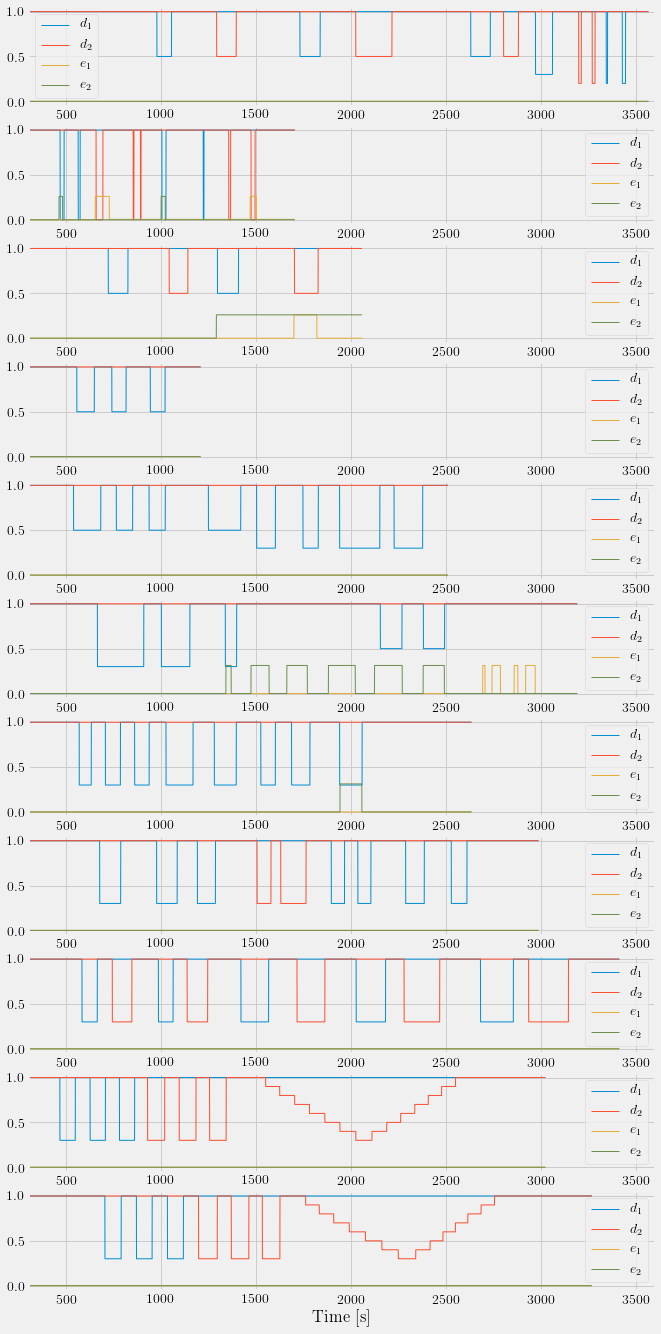

In [7]:
def plot_faults(df):
    df.m1.plot(label='$d_1$')
    df.m2.plot(label='$d_2$')
    df.add1.plot(label='$e_1$')
    df.add2.plot(label='$e_2$')

# import matplotlib as mpl
mpl.style.use('fivethirtyeight') #seaborn, default, seaborn-paper
plt.rcParams["font.family"] = "Times New Roman"#"Arial"
plt.rcParams["font.size"] = 14
plt.rcParams["text.usetex"] = True
plt.rcParams["lines.linewidth"] = 1

fig= plt.figure(figsize=(10,22))
column_nr = 1
plot_increment = 1
for df_ in df_list:
    plt.subplot(len(df_list), 1 , plot_increment);
    plot_faults(df_)
    plt.xlim([300,3600])
    plt.xlabel('Time [s]')
    plt.legend()
#     plt.grid()
    if plot_increment==len(df_list):
        plt.legend()
    plot_increment +=1
plt.savefig('plots/flights_all.pdf', dpi=90, bbox_inches='tight')
plt.show()

# Preparing to do a simple binary classification

In [8]:
def plot_ROC_cross_val(classifier, X, y, fname=None):
    from sklearn.metrics import auc
    from sklearn.metrics import plot_roc_curve
    from sklearn.model_selection import StratifiedKFold
    # #############################################################################
    # Classification and ReceiverOperatingCharacteristics analysis with cross-validation

    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=5)
    #classifier = SVC(kernel='rbf', probability=True, random_state=42)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    mpl.style.use('fivethirtyeight')
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 12
    plt.rcParams["text.usetex"] = True
    plt.rcParams["lines.linewidth"] = 1
    
    fig, ax = plt.subplots(figsize=(7,6))
    #fig.set_size_inches(18.5, 10.5)
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = plot_roc_curve(classifier, X[test], y[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.6, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', 
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver Operating Characteristic Curve")
    ax.legend(loc="lower right")
    if fname != None :
        plt.savefig(fname, dpi=90, bbox_inches='tight')
    plt.show()

In [9]:
def plot_ROC_(classifier, X, y, fname=None, title=None):
    from sklearn.metrics import auc
    from sklearn.metrics import plot_roc_curve
    from sklearn.model_selection import StratifiedKFold
    # #############################################################################
    # Classification and ReceiverOperatingCharacteristics analysis with cross-validation

    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=5)
    #classifier = SVC(kernel='rbf', probability=True, random_state=42)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    mpl.style.use('fivethirtyeight')
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 17
    plt.rcParams["text.usetex"] = True
    plt.rcParams["lines.linewidth"] = 1
    
    fig, ax = plt.subplots(figsize=(7,6))
    #fig.set_size_inches(18.5, 10.5)
    for i, (train, test) in enumerate(cv.split(X, y)):
        #classifier.fit(X[train], y[train])
        viz = plot_roc_curve(classifier, X[train], y[train],
                             name='ROC fold {}'.format(i),
                             alpha=0.6, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', 
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')
    
    if title==None:
        title="Receiver Operating Characteristic Curve"
        
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title=title)
    ax.legend(loc="lower right")
    if fname != None :
        plt.savefig(fname, dpi=90, bbox_inches='tight')
    plt.show()

In [10]:
# Assigning fault labels for 2 different flight days: 
# Any multiplicative or additive modification is taken as fault !
df_12 = assign_fault(df_12)
df_13 = assign_fault(df_13)

In [91]:
# Checking which part of the flight is going to be used... 
# df_12[['mode', 'alt','fault']].loc[500:1400].plot()
# df_13[['mode', 'alt','fault']].loc[500:1400].plot()
# df_12[['mode','fault']].loc[500:1400].plot()
# df_13[['mode','fault']].loc[500:1400].plot()

## Flight Trajectory on $12^{th}$ and $13^{th}$ of July 2020 in Muret  (close to Toulouse France)

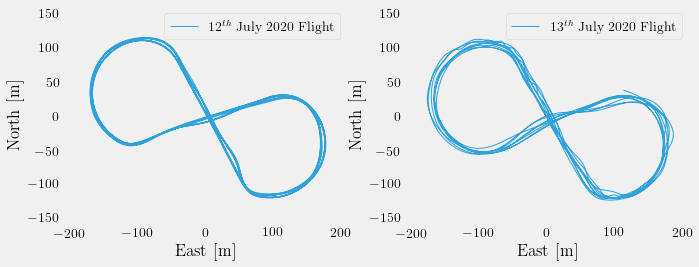

In [11]:
mpl.style.use('fivethirtyeight') #seaborn, default, seaborn-paper
plt.rcParams["font.family"] = "Times New Roman"#"Arial"
plt.rcParams["font.size"] = 14
plt.rcParams["text.usetex"] = True
plt.rcParams["lines.linewidth"] = 1


fig = plt.figure(figsize=(10,5))
plt.subplot(121)
east  = df_12.east[500:1400].values/100 -3.6033e+05
north = df_12.north[500:1400].values/100 -4.813715e+06
plt.plot(east, north, '-', label='$12^{th}$ July 2020 Flight',alpha=0.8) #, c='k')
plt.axis('scaled')
plt.xlim(-210,210);plt.ylim(-160,160)
plt.xlabel('East [m]')
plt.ylabel('North [m]')
plt.grid()
plt.legend()

plt.subplot(122)
east  = df_13.east[500:1400].values/100 -3.6033e+05
north = df_13.north[500:1400].values/100 -4.813715e+06
plt.plot(east, north, '-', label='$13^{th}$ July 2020 Flight',alpha=0.8) #, c='k')
plt.axis('scaled')
plt.xlim(-210,210);plt.ylim(-160,160)
plt.xlabel('East [m]')
plt.ylabel('North [m]')
plt.grid()
plt.legend()

plt.savefig('plots/flight_12_13_trajectory.pdf', dpi=90, bbox_inches='tight')
plt.show()

In [16]:
class Time():
    def __init__(self, start, end):
        self.start = start
        self.end = end
        
def train_SVM(df, time=None, features=['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz', 'C1', 'C2'], targets=['nominal', 'faulty']):
    # Create the Feature and Label List
    columns=features #['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz', 'C1', 'C2']
    if time==None:
        flight = df.copy()
    else:
        flight = df[time.start:time.end].copy()                                                                                                                     
    X_pre = flight[columns].values # Features          
    y = flight.fault.values   # Labels
    X_sd,y_sd = add_time_history_1(X_pre,y,n_step= 20)

    X_train, X_test, y_train, y_test = ms.train_test_split(X_sd, y_sd, test_size=0.2, random_state=42, stratify=y_sd)
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    tuned_parameters = [{'kernel': ['rbf'], 'gamma': ['auto'], 'C': [1, 5, 10, 20]}]
    score = 'f1_micro'
    # score = 'accuracy'

    print("# Tuning hyper-parameters for %s" % score)
    print()

    # cv : For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. In all other cases, KFold is used.
    clf = GridSearchCV(SVC(), tuned_parameters, scoring=score)  # scoring='%s_micro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    target_names = targets
    print(classification_report(y_true, y_pred, target_names=target_names))
    print('Matthews Correlation Coefficient : ',  matthews_corrcoef(y_true, y_pred))
    return clf, scaler

def predict_SVM(model, scaler, df, time=None, features=['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz', 'C1', 'C2'], targets=['nominal', 'faulty']):
    # Create the Feature and Label List
    columns=features
    if time==None:
        flight = df.copy()
    else:
        flight = df[time.start:time.end].copy()                                                                                                                    
    X_pre = flight[columns].values # Features          
    y = flight.fault.values   # Labels
    X_sd,y_sd = add_time_history_1(X_pre,y,n_step= 20)

    X_sd_scaled = scaler.transform(X_sd)
    X_sd_scaled_reduced = X_sd_scaled[::20,:].copy()
    y_sd_reduced = y_sd[::20].copy()
    y_sd_pred = model.predict(X_sd_scaled_reduced)

#     target_names = ['nominal', 'R0.3', 'L0.9', 'L0.8','L0.7', 'L0.6', 'L0.5', 'L0.4', 'L0.3']
    print(classification_report(y_sd_reduced, y_sd_pred, target_names=target_names))
    return y_sd_reduced, y_sd_pred

In [137]:
# plot_ROC_cross_val(clf, X_sd_scaled_reduced, y_sd_reduced, fname='plots/flight_13_model_12_ROC.pdf')
# plot_ROC_cross_val(clf, X_sd_scaled_reduced, y_sd_reduced)

## Train - test - validate and report  using only $12^{th}$ of July flight data

In [17]:
# time class to define the portion of the flight to be used during training
time = Time(500,1400)
# Lots of things going on inside train_SVM() function, so please check out the above definition for more info
clf, scaler = train_SVM(df_12, time, targets = ['Nominal', 'Faulty'] )

# Tuning hyper-parameters for f1_micro

Best parameters set found on development set:

{'C': 5, 'gamma': 'auto', 'kernel': 'rbf'}

Grid scores on development set:

0.978 (+/-0.006) for {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
0.983 (+/-0.008) for {'C': 5, 'gamma': 'auto', 'kernel': 'rbf'}
0.983 (+/-0.008) for {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
0.981 (+/-0.007) for {'C': 20, 'gamma': 'auto', 'kernel': 'rbf'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

     Nominal       0.99      0.99      0.99       843
      Faulty       0.99      0.99      0.99       956

    accuracy                           0.99      1799
   macro avg       0.99      0.99      0.99      1799
weighted avg       0.99      0.99      0.99      1799

Matthews Correlation Coefficient :  0.9799400202934504


In [18]:
# All is good with the classifier ? 0 : Good!
clf.best_estimator_.fit_status_

0

## Use the above trained model in order to predict next day's faults from flight data 

In [20]:
# Create the Feature and Label List
columns=['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz', 'C1', 'C2']
# columns=[ 'Gx', 'Gy', 'Gz', 'C1', 'C2']
flight = df_13[500:1400].copy()                                                                                                                     
X_pre = flight[columns].values # Features          
y = flight.fault.values   # Labels
X_sd,y_sd = add_time_history_1(X_pre,y,n_step= 20)

X_sd_scaled = scaler.transform(X_sd)
X_sd_scaled_reduced = X_sd_scaled[::20,:].copy()
y_sd_reduced = y_sd[::20].copy()
y_sd_pred = clf.predict(X_sd_scaled_reduced)

target_names =  ['Nominal', 'Faulty']
print(classification_report(y_sd_reduced, y_sd_pred, target_names=target_names))
print('Matthews Correlation Coefficient : ',  matthews_corrcoef(y_sd_reduced, y_sd_pred))

              precision    recall  f1-score   support

     Nominal       0.93      0.43      0.59       293
      Faulty       0.47      0.94      0.63       157

    accuracy                           0.61       450
   macro avg       0.70      0.68      0.61       450
weighted avg       0.77      0.61      0.60       450

Matthews Correlation Coefficient :  0.38491308534979685


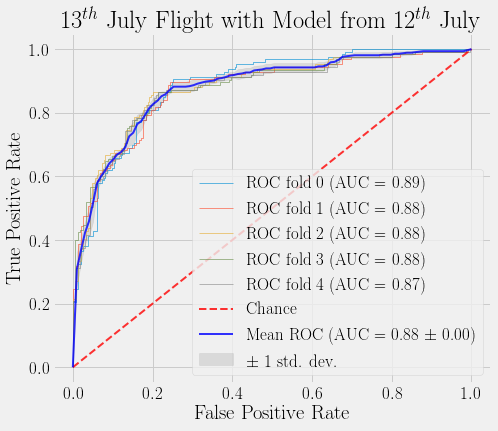

In [21]:
# clf = SVC(C=10, kernel='rbf', gamma='auto')
# plot_ROC_cross_val(clf, X_sd_scaled_reduced, y_sd_reduced)
# plot_ROC_cross_val(clf, X_sd_scaled, y_sd)
# plot_ROC_(clf, X_sd_scaled_reduced, y_sd_reduced, fname='plots/flight_12_model_13_ROC.pdf', title='$12^{th}$ July Flight with Model from $13^{th}$ July')
plot_ROC_(clf, X_sd_scaled_reduced, y_sd_reduced, fname='plots/flight_13_model_12_ROC.pdf', title='$13^{th}$ July Flight with Model from $12^{th}$ July')

## State/Status Filter to set as a decision boundary

In [290]:
status = np.zeros([len(y_sd_pred)])
i=0; increment=0; state=0
for info in y_sd_pred:
    if info!=state : 
        increment += 1
    else:
        increment = 0
    if increment >= 3 : state = info
    status[i] = state
    i +=1

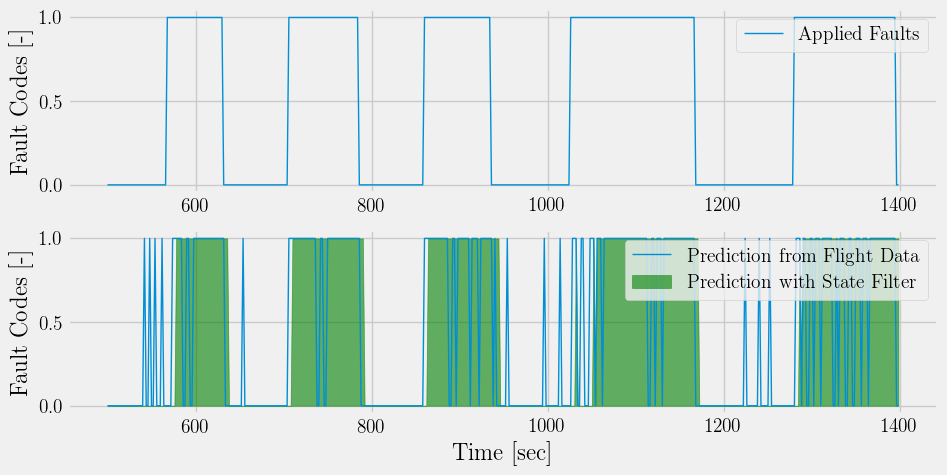

In [291]:
mpl.style.use('fivethirtyeight')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
plt.rcParams["text.usetex"] = True
plt.rcParams["lines.linewidth"] = 1
pp = 2 # Prediction Period : we gather data during 2seconds, and predict once ...
t = range(500, 500+len(y_sd_pred)*pp, pp)

fig = plt.figure(figsize=(10,5))
plt.subplot(211);plt.plot(t, y_sd_reduced, label='Applied Faults');plt.legend();plt.ylabel('Fault Codes [-]')
plt.subplot(212);plt.plot(t, y_sd_pred, label='Prediction from Flight Data')
plt.fill_between(t ,status,0, alpha=0.6, color='green', label='Prediction with State Filter')
plt.legend();plt.ylabel('Fault Codes [-]')
plt.xlabel('Time [sec]')
plt.savefig('plots/flight_12_model_13.pdf', dpi=90, bbox_inches='tight')
plt.show()

In [263]:
range(900,2)

range(900, 2)

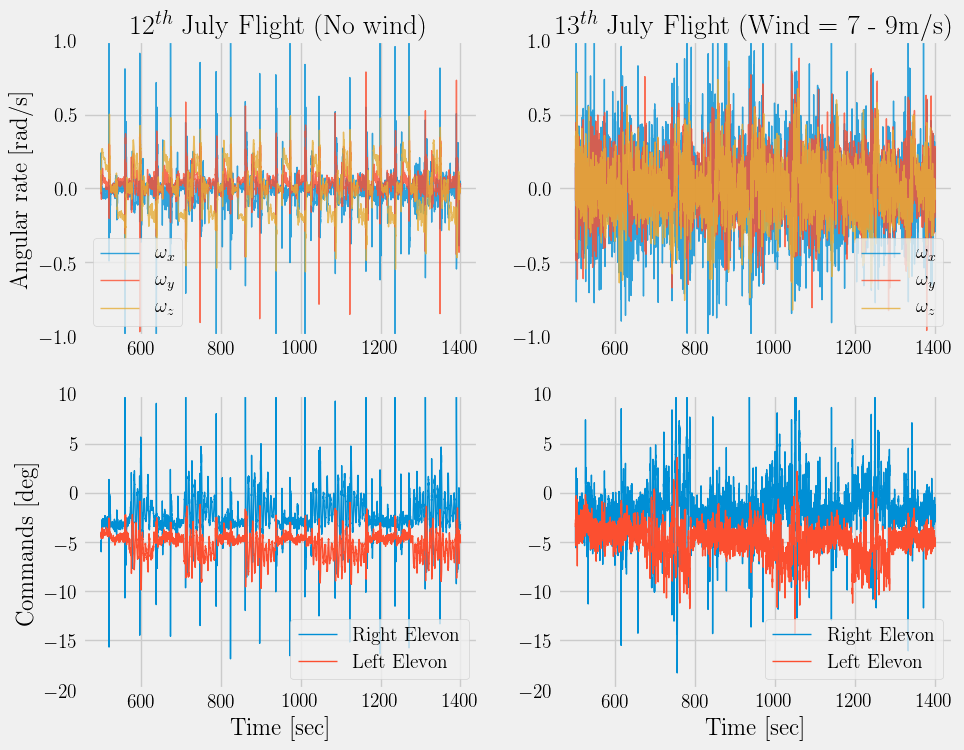

In [297]:
st=500 ; fn=1400;

C1 = df_12[st:fn].C1.values / 9600 * 25 * -1
C2 = df_12[st:fn].C2.values / 9600 * 25
F = df_12[st:fn].fault.values
A = df_12[['Ax','Ay','Az']].loc[st:fn].values
G = df_12[['Gx','Gy','Gz']].loc[st:fn].values
time = df_12[st:fn].index.values

mpl.style.use('fivethirtyeight')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
plt.rcParams["text.usetex"] = True
plt.rcParams["lines.linewidth"] = 1

fig = plt.figure(figsize=(10,8))

plt.subplot(221)
plt.plot(time,G[:,0], alpha=0.8, label='$\omega_x$')
plt.plot(time,G[:,1], alpha=0.8, label='$\omega_y$')
plt.plot(time,G[:,2], alpha=0.8, label='$\omega_z$');plt.legend();plt.ylim([-1,1]);plt.ylabel('Angular rate [rad/s]')
plt.title('$12^{th}$ July Flight (No wind)')

plt.subplot(223)
plt.plot(time,C1, label='Right Elevon')
plt.plot(time,C2, label='Left Elevon');plt.legend();plt.ylim([-20,10]);plt.ylabel('Commands [deg]')
plt.xlabel('Time [sec]')

C1 = df_13[st:fn].C1.values / 9600 * 25 * -1
C2 = df_13[st:fn].C2.values / 9600 * 25
F = df_13[st:fn].fault.values
A = df_13[['Ax','Ay','Az']].loc[st:fn].values
G = df_13[['Gx','Gy','Gz']].loc[st:fn].values
time = df_13[st:fn].index.values

plt.subplot(222)
plt.plot(time,G[:,0], alpha=0.8, label='$\omega_x$')
plt.plot(time,G[:,1], alpha=0.8, label='$\omega_y$')
plt.plot(time,G[:,2], alpha=0.8, label='$\omega_z$');plt.legend();plt.ylim([-1,1])#;plt.ylabel('Angular rate [rad/s]')
plt.title('$13^{th}$ July Flight (Wind = 7 - 9m/s)')

plt.subplot(224)
plt.plot(time,C1, label='Right Elevon')
plt.plot(time,C2, label='Left Elevon');plt.legend();plt.ylim([-20,10])#;plt.ylabel('Commands [deg]')
plt.xlabel('Time [sec]')
plt.savefig('plots/flight_12_13_wind_effect.pdf', dpi=90, bbox_inches='tight')
plt.show()

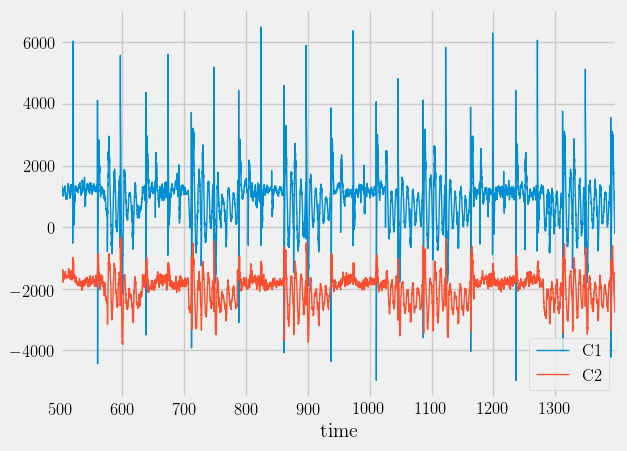

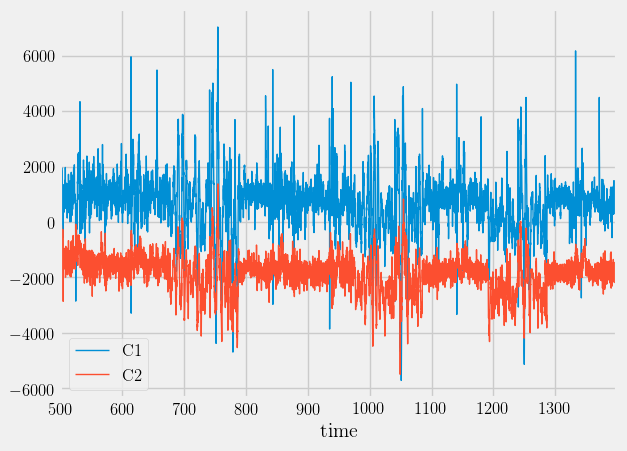

In [232]:
# df_12[['Gx','Gy','Gz']].loc[500:1400].plot()
# df_13[['Gx','Gy','Gz']].loc[500:1400].plot()
df_12[['C1','C2']].loc[500:1400].plot()
df_13[['C1','C2']].loc[500:1400].plot()
# df_12.columns

## Twisted Wing Effect :

In [303]:
df_17 = assign_fault(df_17)
# 
cond = (df_17['m2'] < 0.4); df_17.fault[cond] = 2

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


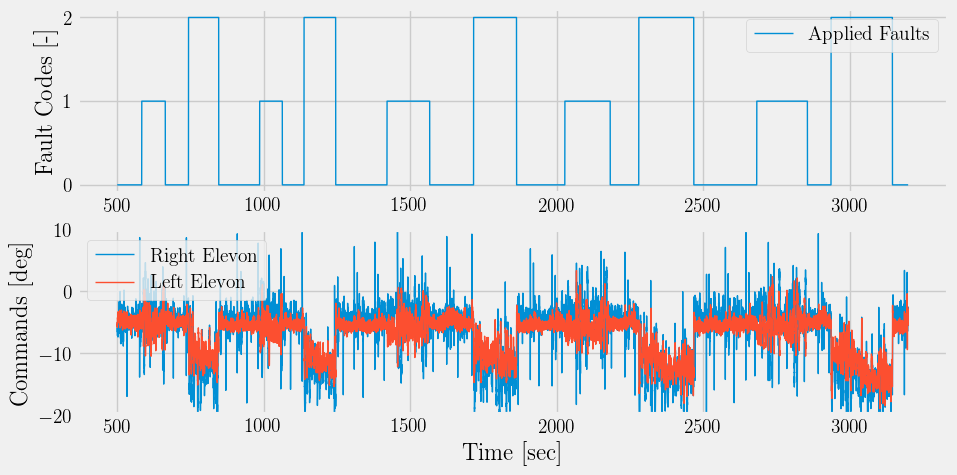

In [313]:
st=500 ; fn=3200;

C1 = df_17[st:fn].C1.values / 9600 * 25 * -1
C2 = df_17[st:fn].C2.values / 9600 * 25
F = df_17[st:fn].fault.values
A = df_17[['Ax','Ay','Az']].loc[st:fn].values
G = df_17[['Gx','Gy','Gz']].loc[st:fn].values
time = df_17[st:fn].index.values

mpl.style.use('fivethirtyeight')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
plt.rcParams["text.usetex"] = True
plt.rcParams["lines.linewidth"] = 1

fig = plt.figure(figsize=(10,5))
plt.subplot(211);plt.plot(time,F, label='Applied Faults');plt.legend();plt.ylabel('Fault Codes [-]') #;plt.title('$17^{th}$ July Flight')
plt.subplot(212)
plt.plot(time,C1, label='Right Elevon');plt.legend();plt.ylim([-20,10]);plt.ylabel('Commands [deg]')
plt.plot(time,C2, label='Left Elevon');plt.legend();plt.ylim([-20,10]);plt.ylabel('Commands [deg]')
plt.xlabel('Time [sec]')

# plt.savefig('plots/flight_17_twisted_wing.pdf', dpi=90, bbox_inches='tight')
plt.show()

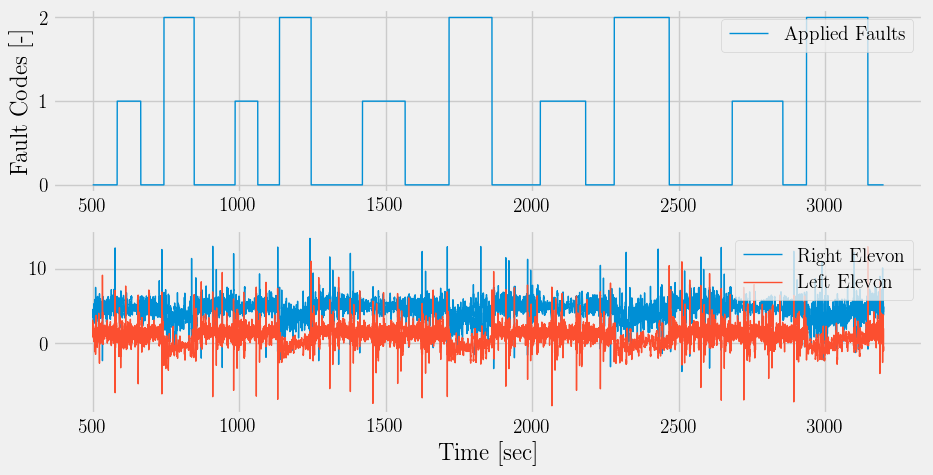

In [317]:
st=500 ; fn=3200;

S1 = (df_17[st:fn].S1.values-1500) / 500 * 25 * -1
S2 = (df_17[st:fn].S2.values-1500) / 500 * 25
F = df_17[st:fn].fault.values
A = df_17[['Ax','Ay','Az']].loc[st:fn].values
G = df_17[['Gx','Gy','Gz']].loc[st:fn].values
time = df_17[st:fn].index.values

mpl.style.use('fivethirtyeight')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
plt.rcParams["text.usetex"] = True
plt.rcParams["lines.linewidth"] = 1

fig = plt.figure(figsize=(10,5))
plt.subplot(211);plt.plot(time,F, label='Applied Faults');plt.legend();plt.ylabel('Fault Codes [-]') #;plt.title('$17^{th}$ July Flight')
plt.subplot(212)
plt.plot(time,S1, label='Right Elevon');plt.legend()#;plt.ylim([-20,10]);plt.ylabel('Commands [deg]')
plt.plot(time,S2, label='Left Elevon');plt.legend()#;plt.ylim([-20,10]);plt.ylabel('Commands [deg]')
plt.xlabel('Time [sec]')

plt.show()

## MultiClass Classification

In [8]:
# Add fault label to the dataframe
df_21 = assign_fault(df_21)

In [9]:
# df_flight_multi = df_flight.copy()
cond = (df_21['m2'] < 1.0)   # df.loc[cond,'fault'] = 1
df_21.fault[cond] = 2
cond = (df_21['m2'] < 0.9); df_21.fault[cond] = 3
cond = (df_21['m2'] < 0.8); df_21.fault[cond] = 4
cond = (df_21['m2'] < 0.7); df_21.fault[cond] = 5
cond = (df_21['m2'] < 0.6); df_21.fault[cond] = 6
cond = (df_21['m2'] < 0.5); df_21.fault[cond] = 7
cond = (df_21['m2'] < 0.4); df_21.fault[cond] = 8

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

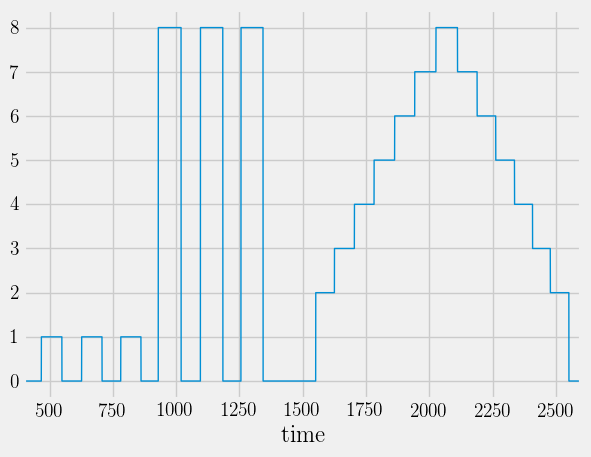

In [310]:
df_21[400:2600].fault.plot()

In [12]:
time = Time(400,2600)

In [64]:
clf, scaler = train_SVM(df_21, time, targets = ['nominal', 'R0.3', 'L0.9', 'L0.8','L0.7', 'L0.6', 'L0.5', 'L0.4', 'L0.3'] )
# joblib.dump(clf,     'svm_model_multi_21072020_AGC_20h_10s.joblib')
# joblib.dump(scaler, 'svm_scaler_multi_21072020_AGC_20h_10s.joblib')

# Tuning hyper-parameters for f1_micro

Best parameters set found on development set:

{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

Grid scores on development set:

0.881 (+/-0.005) for {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
0.922 (+/-0.006) for {'C': 5, 'gamma': 'auto', 'kernel': 'rbf'}
0.923 (+/-0.008) for {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
0.921 (+/-0.008) for {'C': 20, 'gamma': 'auto', 'kernel': 'rbf'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

     nominal       0.92      0.98      0.94      1382
        R0.3       0.98      0.93      0.95       485
        L0.9       0.85      0.70      0.77       295
        L0.8       0.87      0.90      0.88       299
        L0.7       0.94      0.90      0.92       299
        L0.6       0.89      0.90      0.90       311
        L0.5       0.91      0.89      0.90       306
       

In [318]:
clf = joblib.load('svm_model_multi_21072020_AGC_20h_10s.joblib')
scaler = joblib.load('svm_scaler_multi_21072020_AGC_20h_10s.joblib')

# Create the Feature and Label List
columns=['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz', 'C1', 'C2']
# columns=[ 'Gx', 'Gy', 'Gz', 'C1', 'C2']
flight = df_21[400:2600].copy()                                                                                                                     
X_pre = flight[columns].values # Features          
y = flight.fault.values   # Labels
X_sd,y_sd = add_time_history_1(X_pre,y,n_step= 20)

X_sd_scaled = scaler.transform(X_sd)
X_sd_scaled_reduced = X_sd_scaled[::20,:].copy()
y_sd_reduced = y_sd[::20].copy()
y_sd_pred = clf.predict(X_sd_scaled_reduced)

In [319]:
target_names = ['nominal', 'R0.3', 'L0.9', 'L0.8','L0.7', 'L0.6', 'L0.5', 'L0.4', 'L0.3']
print(classification_report(y_sd_reduced, y_sd_pred, target_names=target_names))

              precision    recall  f1-score   support

     nominal       0.94      0.95      0.95       346
        R0.3       0.88      0.98      0.93       121
        L0.9       0.97      0.84      0.90        74
        L0.8       0.99      0.92      0.95        74
        L0.7       0.89      0.95      0.92        75
        L0.6       0.90      0.90      0.90        78
        L0.5       0.96      0.91      0.93        77
        L0.4       0.92      0.96      0.94        81
        L0.3       0.99      0.95      0.97       175

    accuracy                           0.94      1101
   macro avg       0.94      0.93      0.93      1101
weighted avg       0.94      0.94      0.94      1101



In [320]:
matthews_corrcoef(y_sd_reduced, y_sd_pred)

0.9272561564719337

In [321]:
status = np.zeros([len(y_sd_pred)])
i=0; increment=0; state=0
for info in y_sd_pred:
    if info!=state : 
        increment += 1
    else:
        increment = 0
    if increment >= 3 : state = info
    status[i] = state
    i +=1

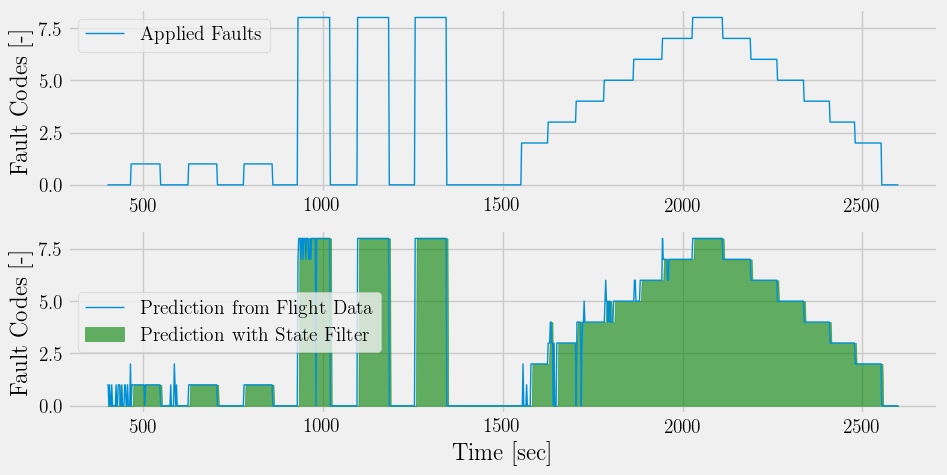

In [323]:
mpl.style.use('fivethirtyeight')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
plt.rcParams["text.usetex"] = True
plt.rcParams["lines.linewidth"] = 1
pp = 2 # Prediction Period : we gather data during 2seconds, and predict once ...
t = range(400, 400+len(y_sd_pred)*pp, pp)

fig = plt.figure(figsize=(10,5))
plt.subplot(211);plt.plot(t, y_sd_reduced, label='Applied Faults');plt.legend();plt.ylabel('Fault Codes [-]')
plt.subplot(212);plt.plot(t, y_sd_pred, label='Prediction from Flight Data')#;plt.legend();plt.ylabel('Fault Codes [-]')
plt.fill_between(t ,status,0, alpha=0.6, color='green', label='Prediction with State Filter')
plt.legend();plt.ylabel('Fault Codes [-]')
plt.xlabel('Time [sec]')
plt.savefig('plots/flight_21.pdf', dpi=90, bbox_inches='tight')
plt.show()

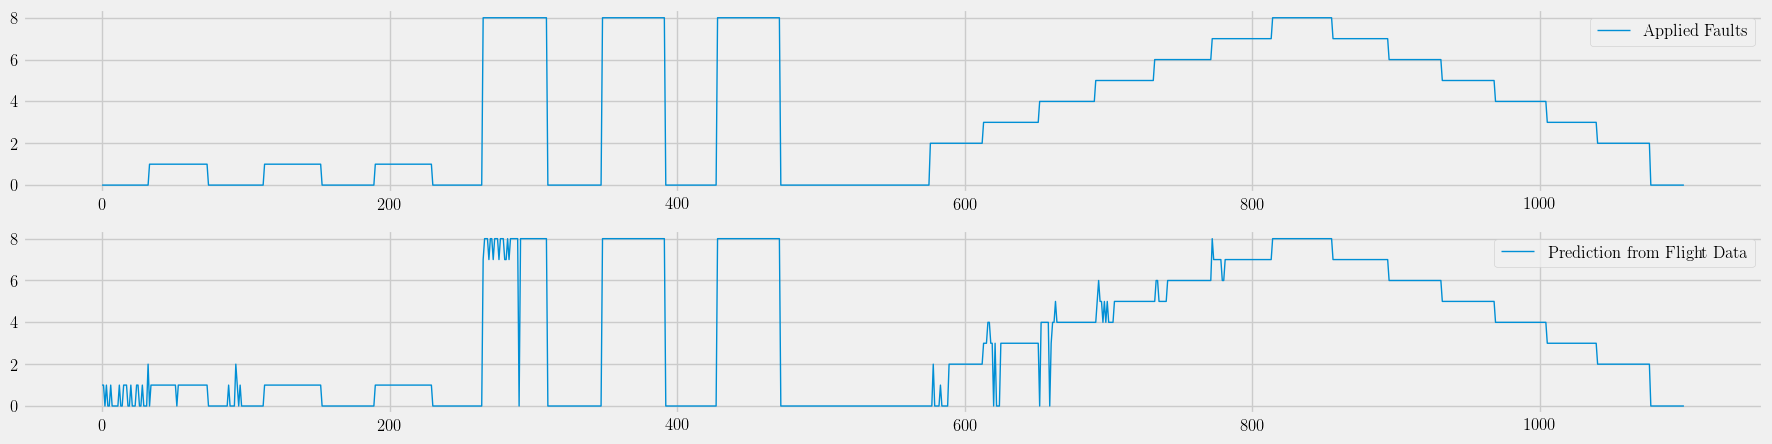

In [26]:
st=400 ; fn=2400;
offset=-9.2;
# y_label = df_labelled[st:fn].m1.values[10:]
y_gcs = gcs21.df_All[st+offset:fn+offset].Fault_Telemetry.values
# y_gcs = data_gcs.df_All[st:fn].Fault_Telemetry.values
# t=np.arange(0,2000.2,0.1)
# tt=np.arange(0,2000.0,0.1)
# import matplotlib as mpl
# mpl.style.use('default') #seaborn, default, seaborn-paper
# plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["font.size"] = 14
fig = plt.figure(figsize=(20,5))
plt.subplot(211);plt.plot(y_sd_reduced, label='Applied Faults');plt.legend()
plt.subplot(212);plt.plot(y_sd_pred, label='Prediction from Flight Data');plt.legend()
# plt.savefig('plots/expected_inflight_added_c1c2.pdf', dpi=90, bbox_inches='tight')
plt.show()

In [394]:
mpl.style.available

['seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'fivethirtyeight',
 'seaborn-whitegrid',
 'classic',
 '_classic_test',
 'fast',
 'seaborn-talk',
 'seaborn-dark-palette',
 'seaborn-bright',
 'seaborn-pastel',
 'grayscale',
 'seaborn-notebook',
 'ggplot',
 'seaborn-colorblind',
 'seaborn-muted',
 'seaborn',
 'Solarize_Light2',
 'seaborn-paper',
 'bmh',
 'tableau-colorblind10',
 'seaborn-white',
 'dark_background',
 'seaborn-poster',
 'seaborn-deep']

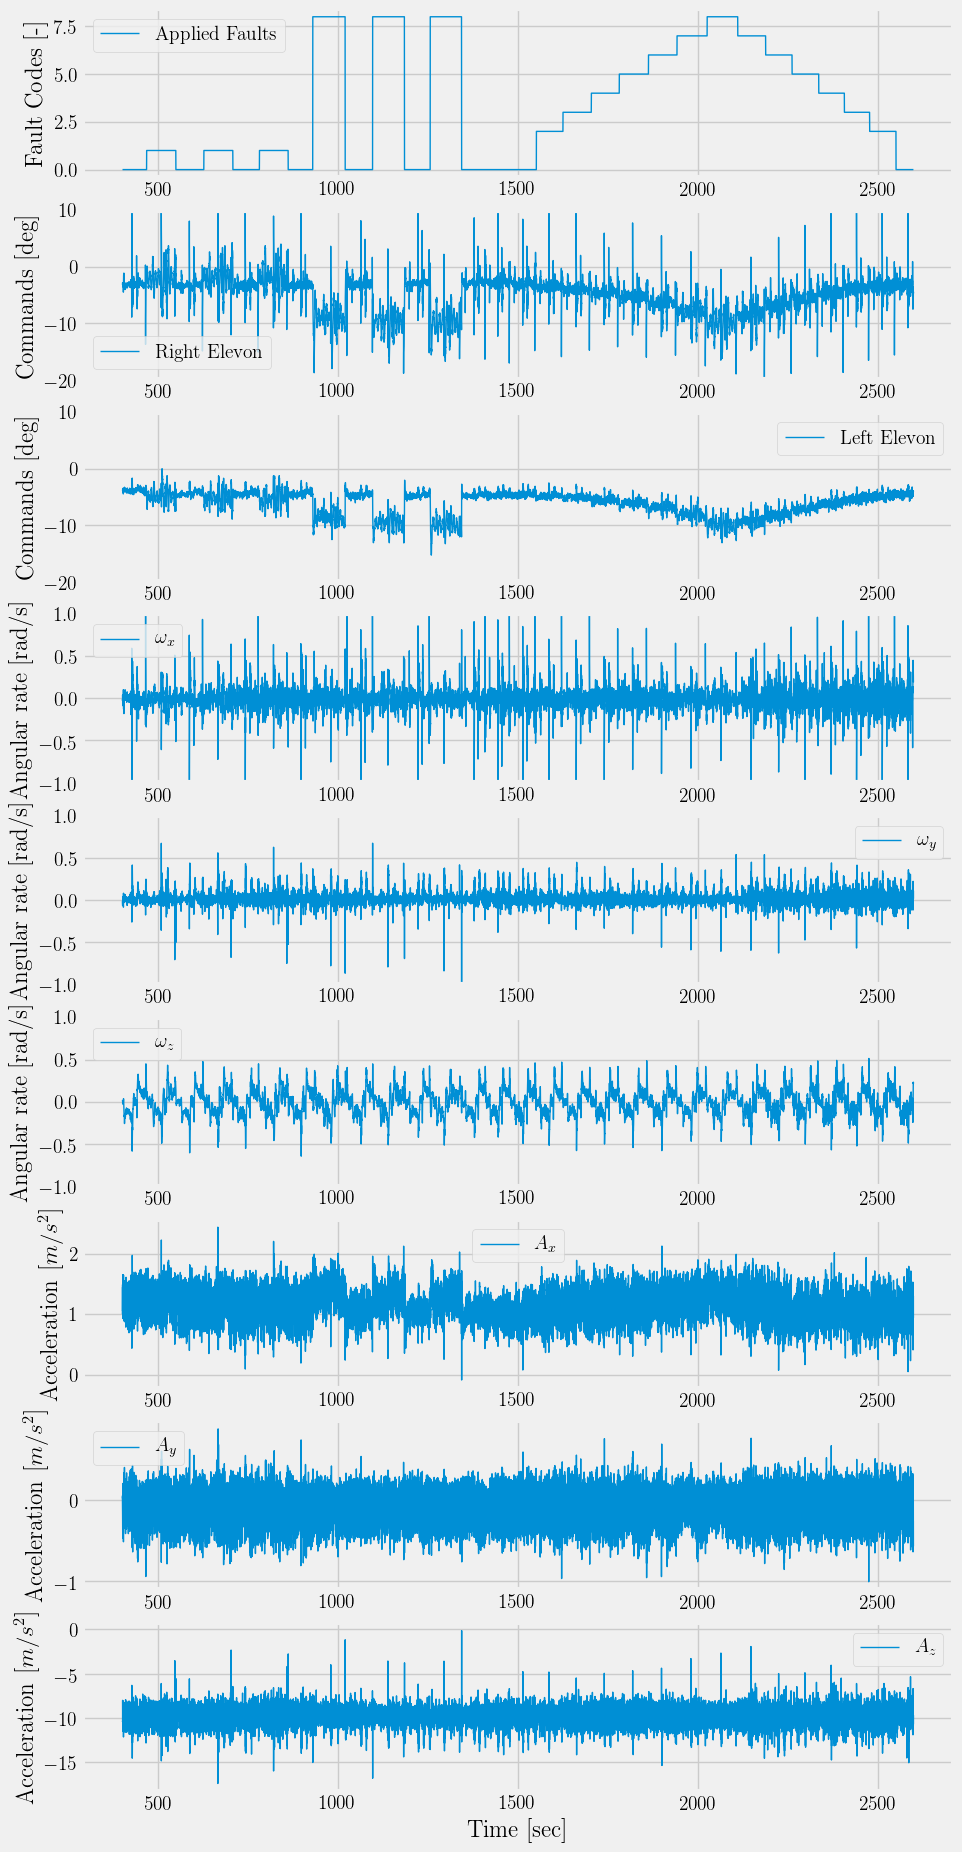

In [344]:
# import matplotlib as mpl
mpl.style.use('fivethirtyeight') #seaborn, default, seaborn-paper
plt.rcParams["font.family"] = "Times New Roman"#"Arial"
plt.rcParams["font.size"] = 14
plt.rcParams["text.usetex"] = True
plt.rcParams["lines.linewidth"] = 1
# mathtext.rm  : serif
# mathtext.it  : serif:italic
# mathtext.bf  : serif:bold
# mathtext.fontset: custom

st=400 ; fn=2600;
C1 = df_21[st:fn].C1.values / 9600 * 25 * -1
C2 = df_21[st:fn].C2.values / 9600 * 25
F = df_21[st:fn].fault.values
A = df_21[['Ax','Ay','Az']].loc[st:fn].values
G = df_21[['Gx','Gy','Gz']].loc[st:fn].values
time = df_21[st:fn].index.values

fig = plt.figure(figsize=(10,22))
plt.subplot(911);plt.plot(time,F, label='Applied Faults');plt.legend();plt.ylabel('Fault Codes [-]')
plt.subplot(912);plt.plot(time,C1, label='Right Elevon');plt.legend();plt.ylim([-20,10]);plt.ylabel('Commands [deg]')
plt.subplot(913);plt.plot(time,C2, label='Left Elevon');plt.legend();plt.ylim([-20,10]);plt.ylabel('Commands [deg]')
plt.subplot(914);plt.plot(time,G[:,0], label='$\omega_x$');plt.legend();plt.ylim([-1,1]);plt.ylabel('Angular rate [rad/s]')
plt.subplot(915);plt.plot(time,G[:,1], label='$\omega_y$');plt.legend();plt.ylim([-1,1]);plt.ylabel('Angular rate [rad/s]')
plt.subplot(916);plt.plot(time,G[:,2], label='$\omega_z$');plt.legend();plt.ylim([-1,1]);plt.ylabel('Angular rate [rad/s]')
plt.subplot(917);plt.plot(time,A[:,0], label='$A_x$');plt.legend();plt.ylabel('Acceleration [$m/s^2$]') #;plt.ylim([-1,1])
plt.subplot(918);plt.plot(time,A[:,1], label='$A_y$');plt.legend();plt.ylabel('Acceleration [$m/s^2$]')#;plt.ylim([-1,1])
plt.subplot(919);plt.plot(time,A[:,2], label='$A_z$');plt.legend();plt.ylabel('Acceleration [$m/s^2$]')#;plt.ylim([-1,1])
plt.xlabel('Time [sec]')
plt.savefig('plots/flight21072020.pdf', dpi=90, bbox_inches='tight')
plt.show()

In [145]:
# df_21[['Ax','Ay','Az']].loc[st:fn]

In [176]:
# joblib.dump(clf,     'svm_model_multi_21072020_AGC_20h_10s.joblib')
# joblib.dump(scaler, 'svm_scaler_multi_21072020_AGC_20h_10s.joblib')

['svm_scaler_binary_multi_21072020_AGC_20h_10s.joblib']

In [30]:
def assign_fault(df):
    df = df.assign(fault=0)
    cond1 = (df['add1'] > 0.005) | (df['add1'] < -0.005)
    cond2 = (df['add2'] > 0.005) | (df['add2'] < -0.005)
    cond3 = (df['m1'] < 1.0) | (df['m2'] < 1.0)
    cond = cond1 | cond2 | cond3
    df.loc[cond,'fault'] = 1
#     cond4 = (df['mode'] == 2.0)
#     df = df[cond4]
    return df

# Add fault label to the dataframe
df_23 = assign_fault(df_23)

In [31]:
# import joblib
# df_flight_multi = df_flight.copy()
cond = (df_23['m2'] < 1.0)   # df.loc[cond,'fault'] = 1
df_23.fault[cond] = 2
cond = (df_23['m2'] < 0.9); df_23.fault[cond] = 3
cond = (df_23['m2'] < 0.8); df_23.fault[cond] = 4
cond = (df_23['m2'] < 0.7); df_23.fault[cond] = 5
cond = (df_23['m2'] < 0.6); df_23.fault[cond] = 6
cond = (df_23['m2'] < 0.5); df_23.fault[cond] = 7
cond = (df_23['m2'] < 0.4); df_23.fault[cond] = 8

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: Setti

# If we use the model from $21^{st}$ flight , here is what we get during $23^{rd}$ flight's real-time prediction

In [325]:
# Create the Feature and Label List
columns=['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz', 'C1', 'C2']
# columns=[ 'Gx', 'Gy', 'Gz', 'C1', 'C2']
flight = df_23[600:2850].copy()                                                                                                                     
X_pre = flight[columns].values # Features          
y = flight.fault.values   # Labels
X_sd,y_sd = add_time_history_1(X_pre,y,n_step= 20)

X_sd_scaled = scaler.transform(X_sd)
X_sd_scaled_reduced = X_sd_scaled[::20,:].copy()
y_sd_reduced = y_sd[::20].copy()
y_sd_pred = clf.predict(X_sd_scaled_reduced)

In [326]:
target_names = ['nominal', 'R0.3', 'L0.9', 'L0.8','L0.7', 'L0.6', 'L0.5', 'L0.4', 'L0.3']
print(classification_report(y_sd_reduced, y_sd_pred, target_names=target_names))

              precision    recall  f1-score   support

     nominal       0.57      0.65      0.60       362
        R0.3       0.50      0.42      0.45       125
        L0.9       0.12      0.18      0.15        71
        L0.8       0.24      0.32      0.27        73
        L0.7       0.45      0.31      0.37        74
        L0.6       0.51      0.28      0.36        76
        L0.5       0.39      0.34      0.36        77
        L0.4       0.29      0.30      0.29        81
        L0.3       0.79      0.70      0.74       187

    accuracy                           0.48      1126
   macro avg       0.43      0.39      0.40      1126
weighted avg       0.50      0.48      0.49      1126



In [327]:
matthews_corrcoef(y_sd_reduced, y_sd_pred)

0.3739206888646887

In [329]:
status = np.zeros([len(y_sd_pred)])
i=0; increment=0; state=0
for info in y_sd_pred:
    if info!=state : 
        increment += 1
    else:
        increment = 0
    if increment >= 3 : state = info
    status[i] = state
    i +=1

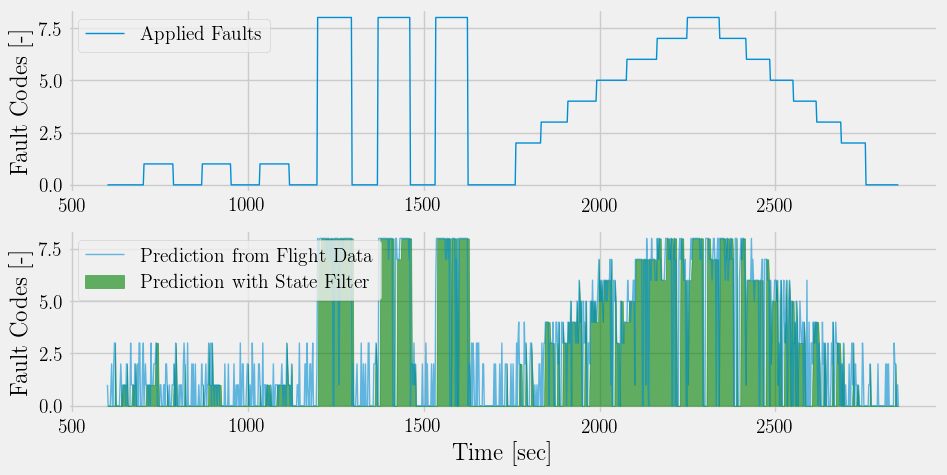

In [333]:
mpl.style.use('fivethirtyeight')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
plt.rcParams["text.usetex"] = True
plt.rcParams["lines.linewidth"] = 1
pp = 2 # Prediction Period : we gather data during 2seconds, and predict once ...
t = range(600, 600+len(y_sd_pred)*pp, pp)

fig = plt.figure(figsize=(10,5))
plt.subplot(211);plt.plot(t, y_sd_reduced, label='Applied Faults');plt.legend();plt.ylabel('Fault Codes [-]')
plt.subplot(212);plt.plot(t, y_sd_pred, alpha=0.6, label='Prediction from Flight Data')#;plt.legend();plt.ylabel('Fault Codes [-]')
plt.fill_between(t ,status,0, alpha=0.6, color='green', label='Prediction with State Filter')
plt.legend();plt.ylabel('Fault Codes [-]')
plt.xlabel('Time [sec]')
plt.savefig('plots/flight_23_model_21.pdf', dpi=90, bbox_inches='tight')
plt.show()

## Now let's concatanate  $21^{st} \& 23^{rd}$ flight datas :

In [77]:
# df_21[['mode', 'alt','fault']].loc[400:2800].plot()
# df_23[['mode', 'alt','fault']].loc[600:3000].plot()

In [34]:
df_21_23 = pd.concat([df_21[400:2800], df_23[600:3000]], ignore_index=True, sort=False)

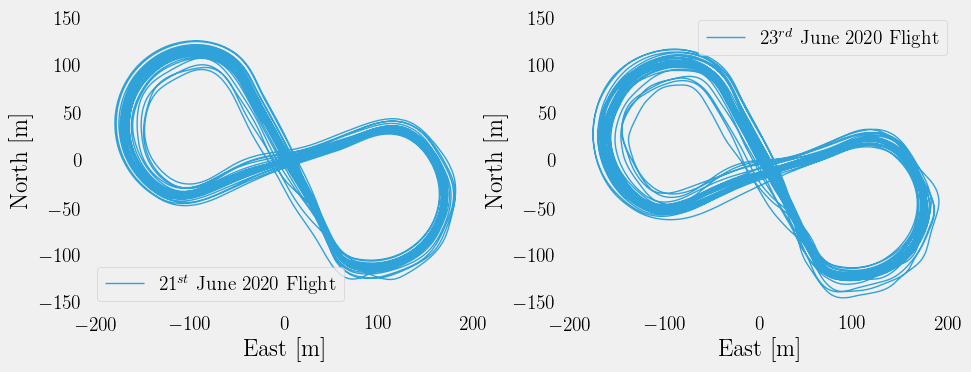

In [324]:
# east  = df_21_23.east.values/100 -3.6033e+05
# north = df_21_23.north.values/100 -4.813715e+06

mpl.style.use('fivethirtyeight') #seaborn, default, seaborn-paper
plt.rcParams["font.family"] = "Times New Roman"#"Arial"
plt.rcParams["font.size"] = 14
plt.rcParams["text.usetex"] = True
plt.rcParams["lines.linewidth"] = 1


fig = plt.figure(figsize=(10,5))
plt.subplot(121)
east  = df_21.east[400:2800].values/100 -3.6033e+05
north = df_21.north[400:2800].values/100 -4.813715e+06
plt.plot(east, north, '-', label='$21^{st}$ June 2020 Flight',alpha=0.8) #, c='k')
plt.axis('scaled')
plt.xlim(-210,210);plt.ylim(-160,160)
plt.xlabel('East [m]')
plt.ylabel('North [m]')
plt.grid()
plt.legend()

plt.subplot(122)
east  = df_23.east[600:3000].values/100 -3.6033e+05
north = df_23.north[600:3000].values/100 -4.813715e+06
plt.plot(east, north, '-', label='$23^{rd}$ June 2020 Flight',alpha=0.8) #, c='k')
plt.axis('scaled')
plt.xlim(-210,210);plt.ylim(-160,160)
plt.xlabel('East [m]')
plt.ylabel('North [m]')
plt.grid()
plt.legend()


plt.savefig('plots/flight_21_23_trajectory.pdf', dpi=90, bbox_inches='tight')
plt.show()

In [36]:
# df_21.east[df_21.fault>0]
# df_21.east.describe()
# north[1000]

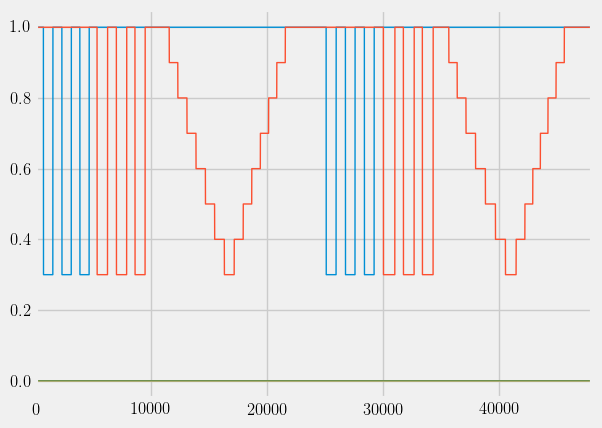

In [37]:
plot_faults(df_21_23)

In [62]:
# Create the Feature and Label List
columns=['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz', 'C1', 'C2']
# columns=[ 'Gx', 'Gy', 'Gz', 'C1', 'C2']
flight = df_21_23.copy()                                                                                                                     
X_pre = flight[columns].values # Features          
y = flight.fault.values   # Labels
X_sd,y_sd = add_time_history_1(X_pre,y,n_step= 20)

X_sd_scaled = scaler.transform(X_sd)
X_sd_scaled_reduced = X_sd_scaled[::20,:].copy()
y_sd_reduced = y_sd[::20].copy()
y_sd_pred = clf.predict(X_sd_scaled_reduced)

target_names = ['nominal', 'R0.3', 'L0.9', 'L0.8','L0.7', 'L0.6', 'L0.5', 'L0.4', 'L0.3']
print(classification_report(y_sd_reduced, y_sd_pred, target_names=target_names))

              precision    recall  f1-score   support

     nominal       0.79      0.81      0.80       878
        R0.3       0.65      0.72      0.68       248
        L0.9       0.41      0.48      0.44       146
        L0.8       0.60      0.67      0.63       147
        L0.7       0.76      0.64      0.70       150
        L0.6       0.72      0.59      0.65       152
        L0.5       0.73      0.67      0.70       155
        L0.4       0.64      0.65      0.65       162
        L0.3       0.89      0.83      0.86       364

    accuracy                           0.73      2402
   macro avg       0.69      0.67      0.68      2402
weighted avg       0.74      0.73      0.73      2402



In [63]:
matthews_corrcoef(y_sd_reduced, y_sd_pred)

0.6653854914173319

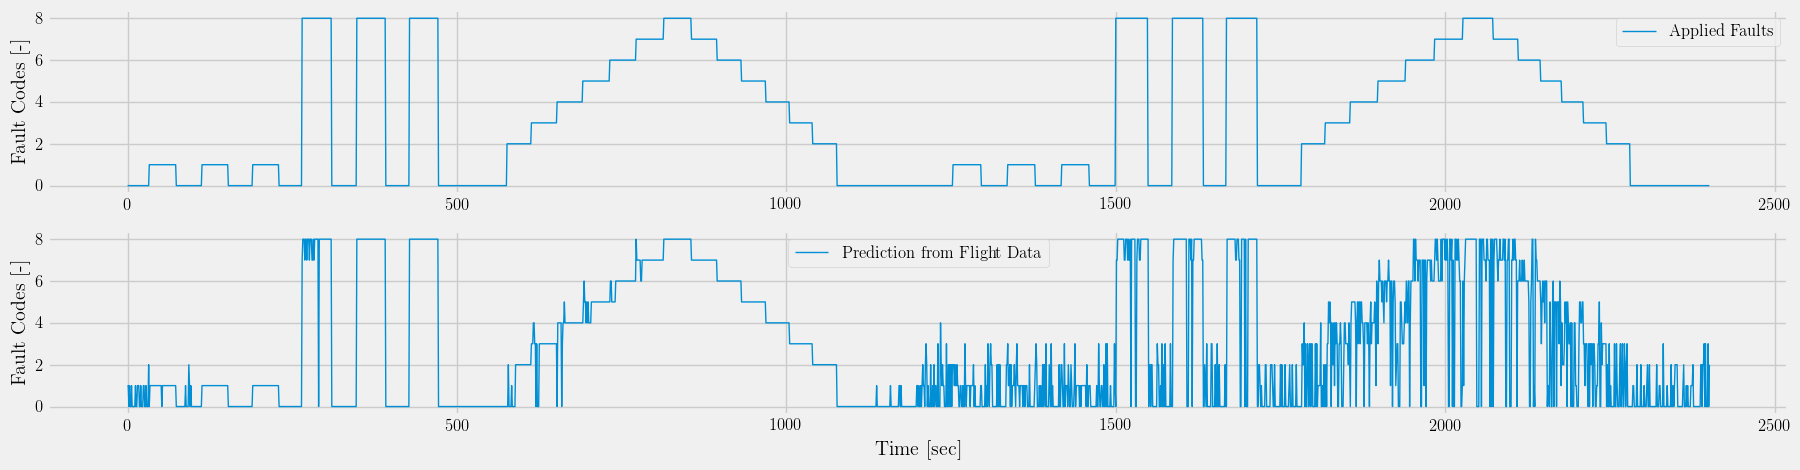

In [64]:
mpl.style.use('fivethirtyeight')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
plt.rcParams["text.usetex"] = True
plt.rcParams["lines.linewidth"] = 1

fig = plt.figure(figsize=(20,5))
plt.subplot(211);plt.plot(y_sd_reduced, label='Applied Faults');plt.legend();plt.ylabel('Fault Codes [-]')
plt.subplot(212);plt.plot(y_sd_pred, label='Prediction from Flight Data');plt.legend();plt.ylabel('Fault Codes [-]')
plt.xlabel('Time [sec]')
plt.savefig('plots/flight_21_23_model_21.pdf', dpi=90, bbox_inches='tight')
plt.show()

## If we Concatenate the 21^{st} and 23^{rd} Flights and train a model by using that data(df_21 and df_23) and then it performs like : 

In [373]:
clf2123, scaler2123 = train_SVM(df_21_23, time=None, targets = ['nominal', 'R0.3', 'L0.9', 'L0.8','L0.7', 'L0.6', 'L0.5', 'L0.4', 'L0.3'] )

# Tuning hyper-parameters for f1_micro

Best parameters set found on development set:

{'C': 5, 'gamma': 'auto', 'kernel': 'rbf'}

Grid scores on development set:

0.835 (+/-0.003) for {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
0.871 (+/-0.003) for {'C': 5, 'gamma': 'auto', 'kernel': 'rbf'}
0.870 (+/-0.005) for {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
0.869 (+/-0.005) for {'C': 20, 'gamma': 'auto', 'kernel': 'rbf'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

     nominal       0.89      0.97      0.93      3521
        R0.3       0.96      0.85      0.91       990
        L0.9       0.69      0.52      0.60       582
        L0.8       0.77      0.75      0.76       590
        L0.7       0.77      0.78      0.77       595
        L0.6       0.82      0.79      0.81       612
        L0.5       0.86      0.86      0.86       616
        

In [378]:
# joblib.dump(clf2123,    'svm_model_multi_21-23_072020_AGC_20h_10s.joblib')
# joblib.dump(scaler2123, 'svm_scaler_multi_21-23_072020_AGC_20h_10s.joblib')

['svm_scaler_binary_multi_21-23_072020_AGC_20h_10s.joblib']

In [44]:
clf2123 = joblib.load('svm_model_multi_21-23_072020_AGC_20h_10s.joblib')
scaler2123 = joblib.load('svm_scaler_multi_21-23_072020_AGC_20h_10s.joblib')

y_2123_true, y_2123_pred = predict_SVM(clf2123, 
                                       scaler2123, 
                                       df_21_23, time=None,
                                       features=['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz', 'C1', 'C2'],
                                       targets = ['nominal', 'R0.3', 'L0.9', 'L0.8','L0.7', 'L0.6', 'L0.5', 'L0.4', 'L0.3'] )

              precision    recall  f1-score   support

     nominal       0.96      0.99      0.98       878
        R0.3       0.99      0.95      0.97       248
        L0.9       0.97      0.82      0.89       146
        L0.8       0.91      0.95      0.93       147
        L0.7       0.95      0.95      0.95       150
        L0.6       0.97      0.93      0.95       152
        L0.5       0.96      0.97      0.96       155
        L0.4       0.96      0.93      0.94       162
        L0.3       0.98      0.99      0.98       364

    accuracy                           0.96      2402
   macro avg       0.96      0.94      0.95      2402
weighted avg       0.96      0.96      0.96      2402



In [53]:
matthews_corrcoef(y_2123_true, y_2123_pred)

0.9531102294001428

In [338]:
status = np.zeros([len(y_2123_pred)])
i=0; increment=0; state=0
for info in y_2123_pred:
    if info!=state : 
        increment += 1
    else:
        increment = 0
    if increment >= 3 : state = info
    status[i] = state
    i +=1

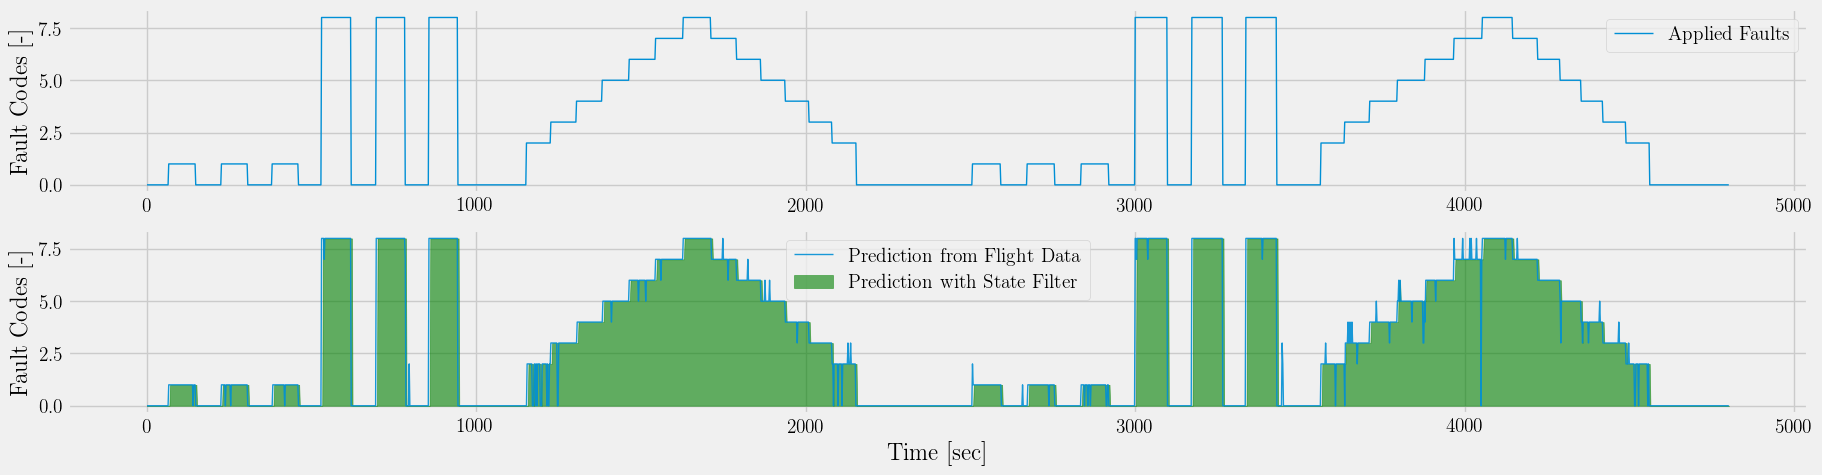

In [343]:
mpl.style.use('fivethirtyeight')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
plt.rcParams["text.usetex"] = True
plt.rcParams["lines.linewidth"] = 1
pp = 2 # Prediction Period : we gather data during 2seconds, and predict once ...
t = range(0, 0+len(y_2123_pred)*pp, pp)

fig = plt.figure(figsize=(20,5))
plt.subplot(211);plt.plot(t, y_2123_true, label='Applied Faults');plt.legend();plt.ylabel('Fault Codes [-]')
plt.subplot(212);plt.plot(t, y_2123_pred, alpha=0.9, label='Prediction from Flight Data')#;plt.legend();plt.ylabel('Fault Codes [-]')
plt.fill_between(t ,status,0, alpha=0.6, color='green', label='Prediction with State Filter')
plt.legend();plt.ylabel('Fault Codes [-]')
plt.xlabel('Time [sec]')
plt.savefig('plots/flight_21_23_model_21_23.pdf', dpi=90, bbox_inches='tight')
plt.show()


## Create a feature trajectory to show in the paper : 

In [46]:
# Create the Feature and Label List
columns=['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz', 'C1', 'C2']
# columns=[ 'Gx', 'Gy', 'Gz', 'C1', 'C2']
flight = df_21_23.copy()                                                                                                                     
X_pre = flight[columns].values # Features          
y = flight.fault.values   # Labels
X_sd,y_sd = add_time_history_1(X_pre,y,n_step= 20)

X_sd_scaled = scaler.transform(X_sd)
X_sd_scaled_reduced = X_sd_scaled[::20,:].copy()
# y_sd_reduced = y_sd[::20].copy()
# y_sd_pred = clf.predict(X_sd_scaled_reduced)

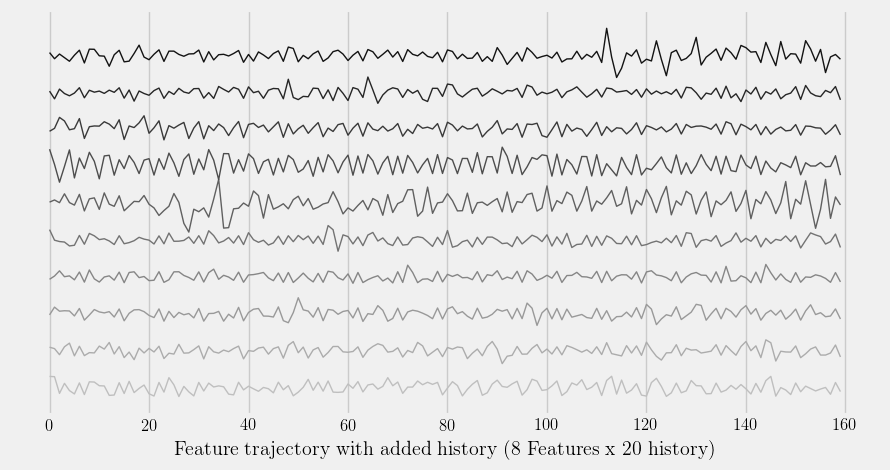

In [48]:
fig= plt.figure(figsize=(10,5))
for i in range(10):
    plt.plot(10*i+X_sd_scaled_reduced[i+2000,:], c=str(0.75-i*0.075)) #Light grey is the oldest - Dark black is the newest data trajectory here!!!

plt.xlabel("Feature trajectory with added history (8 Features x 20 history)")
plt.gca().axes.get_yaxis().set_visible(False)
plt.ylabel('Feature Trajectories')
plt.savefig('plots/feature_trajectories.pdf', dpi=90, bbox_inches='tight')
plt.show()

In [49]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix, multilabel_confusion_matrix
matthews_corrcoef(y_2123_true, y_2123_pred)

0.9531102294001428

In [50]:
confusion_matrix(y_2123_true, y_2123_pred)

array([[872,   2,   2,   1,   0,   0,   0,   1,   0],
       [ 12, 235,   1,   0,   0,   0,   0,   0,   0],
       [ 22,   0, 120,   4,   0,   0,   0,   0,   0],
       [  3,   0,   1, 139,   4,   0,   0,   0,   0],
       [  0,   0,   0,   5, 143,   2,   0,   0,   0],
       [  0,   0,   0,   3,   3, 142,   4,   0,   0],
       [  0,   0,   0,   0,   1,   3, 150,   1,   0],
       [  1,   0,   0,   0,   0,   0,   2, 151,   8],
       [  0,   0,   0,   0,   0,   0,   0,   5, 359]])